# Expressibility

<img src="https://rqc.ru/static/RQClogo_black_ru.png" alt="drawing" height="300">

## Annotation

The following notebook implements **expressibility** estimation for VQC ansatz on qudits

Author: Artem Kuzmichev, Quantum Research Scientist, RQC

In [ ]:
!pip install cirq --quiet --no-warn-conflicts

In [ ]:
import random
import sympy
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import stats, linalg
from sklearn.metrics import mean_squared_error

import cirq
from cirq.contrib.svg import SVGCircuit

##Qudits


We are going to study implementation of qudits for variational circuits. Since the real device we have in FIAN is two-qudit quantim computer with d=4 (ququarts), it appears reasonable to choose this specific value

In [ ]:
d = 4
n = 2

qudits = cirq.LineQid.range(n, dimension=d)
q0, q1 = qudits

print(qudits)

[cirq.LineQid(0, dimension=4), cirq.LineQid(1, dimension=4)]


## My qudit library


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/RQC_Tasks/Qudits/qudit-vqc'

/content/drive/MyDrive/RQC_Tasks/Qudits/qudit-vqc


In [ ]:
from qudit_gates import *
from qudit_depolarization_channels import *
from qudit_variational_qc import *

##Simulation

Qudit Variational Ansatz


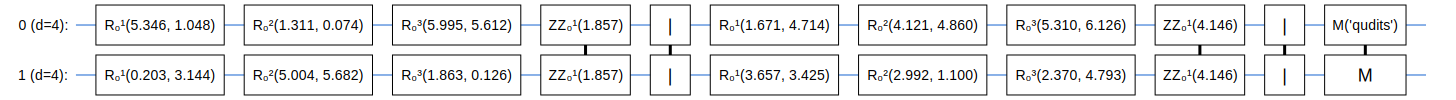

In [ ]:
num_layers = 2  # number of variational layers
num_qudits = 2
num_qudits_pairs = int((num_qudits + 1) * num_qudits / 2)

tl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
pl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
tqtl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qudits_pairs))

print('Qudit Variational Ansatz')
vqc = variational_qc(tl, pl, tqtl, num_layers, num_qudits, measurement=True, with_noise=False)

SVGCircuit(vqc)

In [ ]:
simulator = cirq.Simulator()

theta = sympy.Symbol('t')    

resolver = cirq.ParamResolver({'t': 0.2})
resolved_circuit = cirq.resolve_parameters(vqc, resolver)

results = simulator.run(resolved_circuit, repetitions=1024)
results.histogram(key='qudits', fold_func= lambda bits: ''.join(map(str, bits)))

Counter({'00': 253,
         '20': 320,
         '10': 67,
         '23': 54,
         '31': 15,
         '30': 32,
         '11': 52,
         '03': 30,
         '21': 69,
         '01': 96,
         '12': 19,
         '33': 6,
         '22': 5,
         '13': 6})

##Expressibility

The following code calculate fidelities for two randomly generated circuits. A auxillary function to generate quantum circuit and parameters for this function (if any required) are passed trough arguments of `random_fidelity_simulation()`

The result is a list of fidelities between two states obtained at the end of two circuits

In [ ]:
def variational_qc_generator(num_layers):
    tl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
    pl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
    tqtl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qudits_pairs))

    return variational_qc(tl, pl, tqtl, num_layers, num_qudits)


variational_qc_generator(2)

0 (d=4): ───R₀¹(0.285, 5.184)───R₀²(0.245, 3.489)───R₀³(6.181, 1.584)───ZZ₀¹(0.006)───|───R₀¹(1.722, 3.949)───R₀²(4.166, 3.002)───R₀³(1.110, 3.982)───ZZ₀¹(0.953)───|───
                                                                        │             │                                                               │             │
1 (d=4): ───R₀¹(0.691, 3.174)───R₀²(3.661, 5.754)───R₀³(2.125, 2.776)───ZZ₀¹(0.006)───|───R₀¹(5.357, 5.996)───R₀²(0.640, 2.869)───R₀³(3.544, 0.266)───ZZ₀¹(0.953)───|───

In [ ]:
def noisy_variational_qc_generator(num_layers):
    tl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
    pl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
    tqtl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qudits_pairs))

    return variational_qc(tl, pl, tqtl, num_layers, num_qudits, with_noise=True)

noisy_variational_qc_generator(2)

0 (d=4): ───R₀¹(3.544, 3.288)───Φ(p1=0.011)───R₀²(3.143, 0.482)───Φ(p1=0.011)───R₀³(1.927, 5.625)───Φ(p1=0.011)───ZZ₀¹(2.368)───ΦΦ(p2=0.040)───|───R₀¹(3.819, 2.726)───Φ(p1=0.011)───R₀²(5.087, 3.310)───Φ(p1=0.011)───R₀³(3.416, 4.562)───Φ(p1=0.011)───ZZ₀¹(5.049)───ΦΦ(p2=0.040)───|───
                                                                                                                  │             │              │                                                                                                         │             │              │
1 (d=4): ───R₀¹(0.477, 5.321)───Φ(p1=0.011)───R₀²(3.593, 1.225)───Φ(p1=0.011)───R₀³(3.023, 6.164)───Φ(p1=0.011)───ZZ₀¹(2.368)───ΦΦ(p2=0.040)───|───R₀¹(5.906, 0.805)───Φ(p1=0.011)───R₀²(4.907, 4.197)───Φ(p1=0.011)───R₀³(6.130, 4.166)───Φ(p1=0.011)───ZZ₀¹(5.049)───ΦΦ(p2=0.040)───|───

In [ ]:
def random_fidelity_simulation(qc_generator, pars=[], number_of_samples=1, output=False):
    fidelity_list = []

    for i in range(number_of_samples):
        qc1 = qc_generator(*pars)
        qc2 = qc_generator(*pars)

        rho1 = cirq.DensityMatrixSimulator().simulate(qc1).final_density_matrix
        rho2 = cirq.DensityMatrixSimulator().simulate(qc2).final_density_matrix

        f = cirq.qis.fidelity(rho1, rho2, qid_shape=(4, 4), validate=False)
        fidelity_list.append(f)

        if output:
            display(SVGCircuit(qc1))
            display(SVGCircuit(qc2))
            print(rho1)
            print(rho2)
            print(f'f = {f:.4f}')
        
    return fidelity_list

In [ ]:
N_samples = 100

Fidelities for arbitrary Unitary matrix (Haar)



In [ ]:
def arbitatry_unitary_circuit():
    auqc = cirq.Circuit()
    auqc.append(QuditArbitraryUnitary().on(*qudits))
    return auqc

haar_fidelity_list = random_fidelity_simulation(arbitatry_unitary_circuit, number_of_samples=N_samples)

Fidelities for our variational circuit with different number of layers

SIMULATION TIME = 1 min

In [ ]:
var_data = dict()

for N_layers in range(1, 5):

    var_fidelity_list = random_fidelity_simulation(noisy_variational_qc_generator, pars=[N_layers], number_of_samples=N_samples)

    var_data[N_layers] = var_fidelity_list
    print(f'N = {N_layers} simulated')

N = 1 simulated
N = 2 simulated
N = 3 simulated
N = 4 simulated


In [ ]:
nonoise_data = dict()
for N_layers in range(1, 5):

    nonoise_fidelity_list = random_fidelity_simulation(variational_qc_generator, pars=[N_layers], number_of_samples=N_samples)
    nonoise_data[N_layers] = nonoise_fidelity_list
    print(f'N = {N_layers} simulated')

N = 1 simulated
N = 2 simulated
N = 3 simulated
N = 4 simulated


Plots

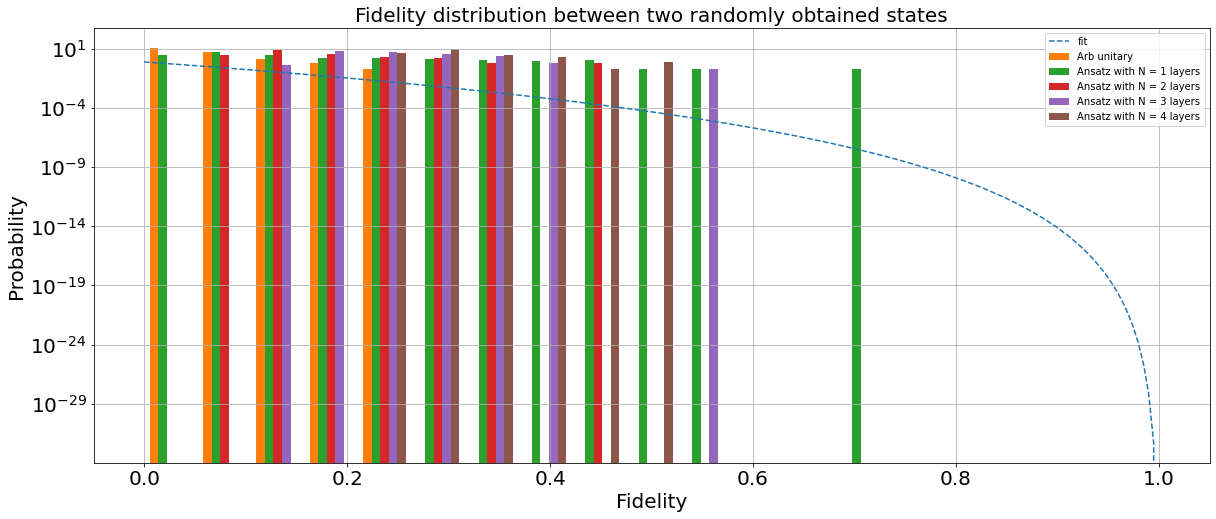

In [ ]:
plt.figure(figsize=(20,8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

n_bins = 20
bins = np.linspace(0, 1, n_bins)

n_histograms = len(var_data) + 1 #different number of layes and 1 histogram for arb unitary
w = np.ones(N_samples) / N_samples # weights for normalization
w = [w] * n_histograms # copy (NOT MULTIPLY) weights array for all histograms

var_data_labels = [f'Ansatz with N = {N_layers} layers' for N_layers in var_data.keys()]

N = 16
x = np.linspace(0, 1, 200)
fit_func = (N - 1) * (1 - x) ** (N - 2) / n_bins
plt.plot(x , fit_func, linestyle='--', label='fit')

hlist = plt.hist([haar_fidelity_list, *var_data.values()], bins, density=True, range=(0, 1), label=['Arb unitary', *var_data_labels])


plt.yscale("log")
plt.grid()
plt.legend(loc='upper right')
plt.title('Fidelity distribution between two randomly obtained states', size=20)
plt.ylabel('Probability', size=20)
plt.xlabel('Fidelity', size=20)
plt.show()

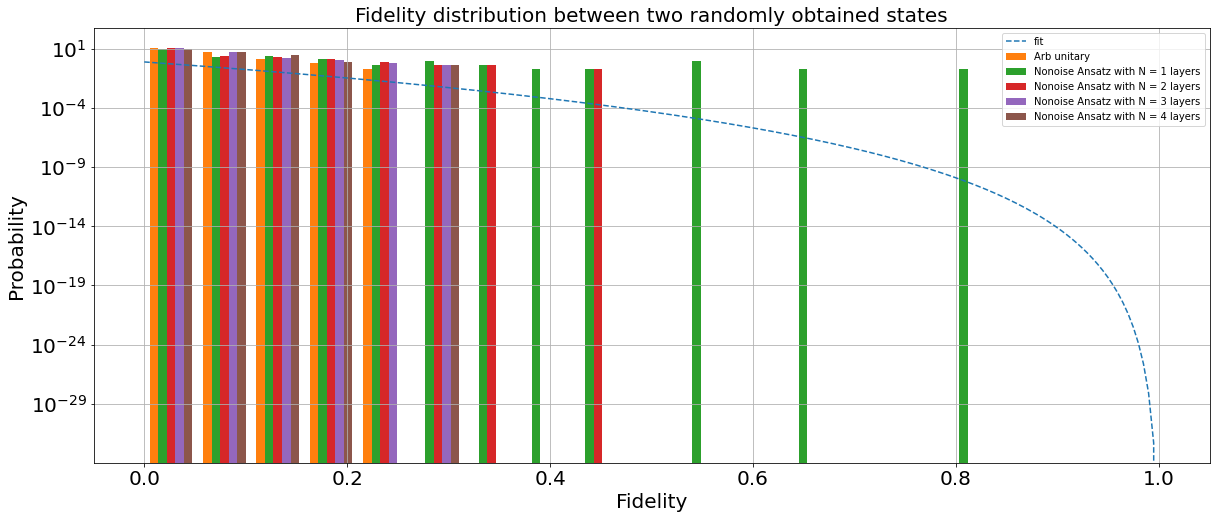

In [ ]:
plt.figure(figsize=(20,8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

n_bins = 20
bins = np.linspace(0, 1, n_bins)

n_histograms = len(nonoise_data) + 1 #different number of layes and 1 histogram for arb unitary
w = np.ones(N_samples) / N_samples # weights for normalization
w = [w] * n_histograms # copy (NOT MULTIPLY) weights array for all histograms

nonoise_data_labels = [f'Nonoise Ansatz with N = {N_layers} layers' for N_layers in var_data.keys()]

N = 16
x = np.linspace(0, 1, 200)
fit_func = (N - 1) * (1 - x) ** (N - 2) / n_bins
plt.plot(x , fit_func, linestyle='--', label='fit')

hlist_nonoise = plt.hist([haar_fidelity_list, *nonoise_data.values()], bins, density=True, range=(0, 1), label=['Arb unitary', *nonoise_data_labels])


plt.yscale("log")
plt.grid()
plt.legend(loc='upper right')
plt.title('Fidelity distribution between two randomly obtained states', size=20)
plt.ylabel('Probability', size=20)
plt.xlabel('Fidelity', size=20)
plt.show()

##Calculationn of DKL

In [ ]:
n_bins = len(hlist[0][1])
x = np.linspace(0, 1, len(hlist[0][1]) + 1)

x = np.array([(x[i] + x[i + 1]) / 2 for i in range(len(x) - 1)])

h_Haar = (N - 1) * (1 - x) ** (N - 2) / n_bins

In [ ]:
def Kullback_Leibner_divergence(h1, h2):
    Dkl = 0
    for i in range(len(h1)):
        if h1[i] != 0:
            Dkl += h1[i] * np.log(h1[i] / h2[i])
    return Dkl

#h_Haar = hlist[0][0]
DKL_list = []

for i in range(1, len(hlist[0])):
    DKL = Kullback_Leibner_divergence(hlist[0][i], h_Haar)
    DKL_list.append(DKL)
    # print(DKL)

In [ ]:
DKL_nonoise = []

for i in range(1, len(hlist_nonoise[0])):
    DKL = Kullback_Leibner_divergence(hlist_nonoise[0][i], h_Haar)
    DKL_nonoise.append(DKL)
    print(DKL)

72.425400028896
58.79843232292294
56.769029751371896
57.127383820506715


In [ ]:
def MSE_divergence(h1):
    n_bins = len(h1 - 1)
    x = np.linspace(0, 1, n_bins)
    fit_func = (N - 1) * (1 - x) ** (N - 2) / n_bins

    return mean_squared_error(h1, fit_func)

MSE_list = [MSE_divergence(hlist[0][i]) for i in range(1, len(hlist[0]))]

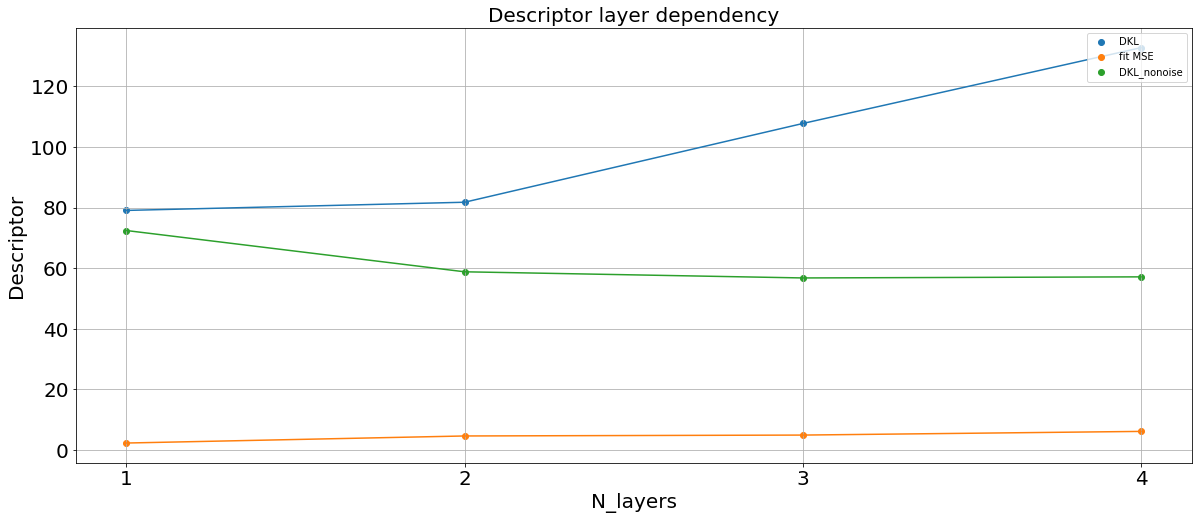

In [ ]:
plt.figure(figsize=(20,8))

x = list(range(1, len(DKL_list) + 1))

plt.xticks(x, fontsize=20)
plt.yticks(fontsize=20)

plt.scatter(x, DKL_list, label='DKL')
plt.plot(x, DKL_list)

plt.scatter(x, MSE_list, label='fit MSE')
plt.plot(x, MSE_list)

x = list(range(1, len(DKL_nonoise) + 1))

plt.scatter(x, DKL_nonoise, label='DKL_nonoise')
plt.plot(x, DKL_nonoise)

plt.legend(loc='upper right')

plt.grid()
plt.title('Descriptor layer dependency', size=20)
plt.ylabel('Descriptor', size=20)
plt.xlabel('N_layers', size=20)
plt.show()

##Sample size dependency


In [ ]:
DKL_sample_dependency = dict()

MSE_sample_dependency = dict()

for sample_size in range(10, N_samples + 1, 10):
        layer_number = 2
        n_bins = int(np.sqrt(sample_size))

        hist_haar = np.histogram(np.array(haar_fidelity_list[:sample_size]), 
                                 n_bins, 
                                 density=True, 
                                 range=(0, 1)
                                 )[0]

        hist_sample = np.histogram(np.array(var_data[layer_number][:sample_size]), 
                                   n_bins, 
                                   density=True, 
                                   range=(0, 1)
                                   )[0]
        
        DKL_sample_dependency[sample_size] = (Kullback_Leibner_divergence(hist_haar, hist_sample))

        MSE_sample_dependency[sample_size] = MSE_divergence(hist_sample)

DKL_sample_dependency

{10: 0.31608154697347846,
 20: 0.6500757179910998,
 30: 1.3285158286650285,
 40: 2.44436212288066,
 50: 4.546891644792504,
 60: 4.699009418198742,
 70: 6.5780022675392615,
 80: 7.160543167453689,
 90: 10.406440883428466,
 100: 15.725323881046178}

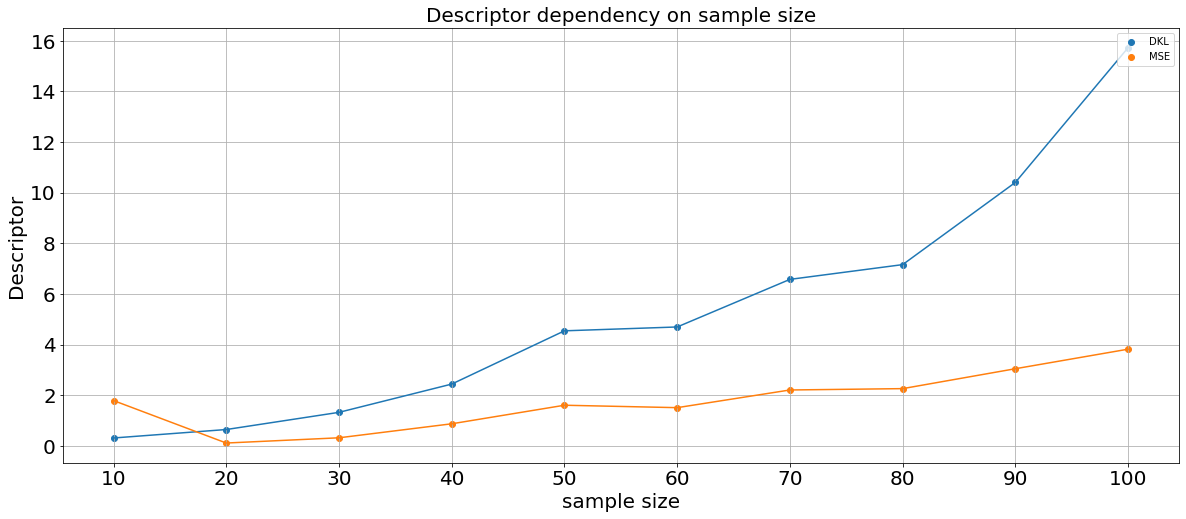

In [ ]:
plt.figure(figsize=(20,8))

x = list(DKL_sample_dependency.keys())
values = list(DKL_sample_dependency.values())

x2 = list(MSE_sample_dependency.keys())
values2 = list(MSE_sample_dependency.values())

plt.xticks(x, fontsize=20)
plt.yticks(fontsize=20)

plt.scatter(x, values, label='DKL')
plt.plot(x, values)

plt.scatter(x2, values2, label='MSE')
plt.plot(x2, values2)

plt.legend(loc='upper right')

plt.grid()
plt.title('Descriptor dependency on sample size', size=20)
plt.ylabel('Descriptor', size=20)
plt.xlabel('sample size', size=20)
plt.show()